In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from tensorflow.keras import backend as K

In [3]:
def custom_loss_function(margin = 5.0):
    def wrapper(y_true, y_pred):
        eucd = y_pred 
        labels_t = y_true
        labels_f = 1 - y_true
        # pos = tf.multiply(labels_t, eucd, name="y_x_eucd")
        pos = labels_t * eucd
        #neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C, eucd)), name="Ny_C-eucd")
        neg = labels_f * K.maximum(0.0,margin - eucd)
        losses = pos + neg
        return K.mean(losses)
    return wrapper

In [122]:
def net():
    model = keras.Sequential()
    model.add(layers.Dense(1024,activation="relu"))
    model.add(layers.Dense(1024,activation="relu"))
    model.add(layers.Dense(2,activation=None))
    model.add(layers.Reshape((2,1)))
    return model

left_input = keras.Input(shape=(28*28,))
right_input = keras.Input(shape=(28*28,))



encoder_l = net()(left_input)
encoder_r = net()(right_input)

## last part

L1_layer =  layers.Lambda(lambda tensor:K.sqrt(K.sum(K.pow(tensor[0]-tensor[1],2), axis=1)+ 1e-6))
#L1_layer =  layers.Lambda(lambda tensor:K.pow(tensor[0]-tensor[1],2))

L1_distance = L1_layer([encoder_l,encoder_r])
#prediction = layers.Dense(1,activation="sigmoid")(L1_distance)

siamese_net = keras.Model(inputs = [left_input,right_input], outputs = L1_distance)

In [123]:
encoder_network_left = keras.Model(inputs=left_input,outputs=encoder_l)

In [151]:
encoder_network_right = keras.Model(inputs=right_input,outputs=encoder_r)

In [125]:
siamese_net.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2, 1)         1855490     input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 2, 1)         1855490     input_4[0][0]                    
____________________________________________________________________________________________

In [126]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train_ = keras.utils.to_categorical(y_train, num_classes)
y_test_ = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [127]:
import tensorflow as tf

In [128]:
siamese_net.compile(optimizer=tf.keras.optimizers.SGD(),loss=custom_loss_function(5.0))#custom_loss_function(5.0)

In [129]:
x_train = x_train.reshape(-1,28*28)

In [130]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [131]:
x_y_train = np.concatenate([x_train,y_train[...,np.newaxis]],axis=1)

In [132]:
import pandas as pd

In [133]:
x_train.shape

(60000, 784)

In [134]:
x_y_train.shape

(60000, 785)

In [135]:
groups = []
for i in range(10):
    groups.append(x_y_train[x_y_train[...,-1] == i])

In [136]:
# def get_pairs_t(groups):
#     pairs = []
#     for g in groups:
#         v = g[:5000]
#         np.random.shuffle(v)
#         print(v[:2500][...,:-1].shape)
#         r = np.concatenate((v[:2500][...,:-1],v[2500:][...,:-1],np.ones((2500,1))),axis=1)
#         pairs.append(r)
#     return np.array(pairs).reshape(-1,((28*28) * 2)+1)#1569

In [157]:
def get_pairs_t(groups):
    pairs = []
    for i in range(-1,len(groups)-1):
        v = groups[i][:5000]
        k = groups[i + 1][:5000]
        np.random.shuffle(v)
        np.random.shuffle(k)
        print(v[:2500][...,:-1].shape)
        r = np.concatenate((v[:2500][...,:-1],k[2500:][...,:-1],np.ones((2500,1))),axis=1)
        pairs.append(r)
    return np.array(pairs).reshape(-1,((28*28) * 2)+1)#1569

In [158]:
b = get_pairs_t(groups)
b.shape

(2500, 784)
(2500, 784)
(2500, 784)
(2500, 784)
(2500, 784)
(2500, 784)
(2500, 784)
(2500, 784)
(2500, 784)
(2500, 784)


(25000, 1569)

In [159]:
def get_pairs_f(groups):
    pairs = []
    for i in range(25):
        for i in range(len(groups)):
            v = groups[i][:5000]
            np.random.shuffle(v)
            ran = i
            while ran == i and ran != i+1:
                ran = np.random.randint(10)

            v2 = groups[ran][:5000]
            np.random.shuffle(v2)


            r = np.concatenate((v[:100][...,:-1],v2[:100][...,:-1],np.zeros((100,1))),axis=1)
            pairs.append(r)
    return np.array(pairs).reshape(-1,((28*28) * 2)+1)#1569

In [160]:
a = get_pairs_f(groups)
a.shape

(25000, 1569)

In [161]:
data_ = np.concatenate([a,b])
data_.shape

(50000, 1569)

In [162]:
np.random.shuffle(data_)

In [163]:
X1 , X2, y = data_[:,:(28*28)], data_[:,(28*28):(28*28)*2] , data_[:,-1:]

In [164]:
y

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]])

In [165]:
siamese_net.fit([X1,X2], y,verbose=1, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 79s 51ms/step - loss: 1.5485
Epoch 2/10
1563/1563 [==============================] - 81s 52ms/step - loss: 1.2818
Epoch 3/10
1563/1563 [==============================] - 79s 51ms/step - loss: 1.1729
Epoch 4/10
1563/1563 [==============================] - 84s 54ms/step - loss: 1.0959
Epoch 5/10
1563/1563 [==============================] - 82s 53ms/step - loss: 1.0362
Epoch 6/10
1563/1563 [==============================] - 83s 53ms/step - loss: 0.9876
Epoch 7/10
1563/1563 [==============================] - 85s 55ms/step - loss: 0.9397
Epoch 8/10
1563/1563 [==============================] - 88s 56ms/step - loss: 0.9038
Epoch 9/10
1563/1563 [==============================] - 87s 56ms/step - loss: 0.8689
Epoch 10/10
1563/1563 [==============================] - 84s 54ms/step - loss: 0.8391


In [166]:
import matplotlib.pyplot as plt

In [167]:
marker = ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']
def plot_pairs(groups,encoder):
    for i,g in enumerate(groups):
        v = g[:5000]
        #np.random.shuffle(v)
        xp = v[:200][...,:-1]
        y = encoder.predict(xp)
        plt.scatter(y[:,0,0],y[:,1,0],marker=marker[i],label=i)
    plt.legend(numpoints=1)

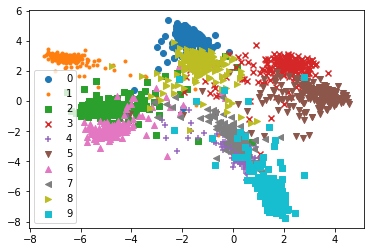

In [168]:
plot_pairs(groups,encoder_network_left)

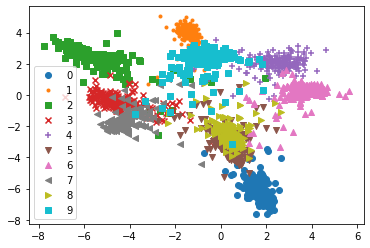

In [169]:
plot_pairs(groups,encoder_network_right)